## Dependencies

In [133]:
# System and Versioning
import sys
import importlib
from packaging import version

# ML
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data Analytics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker

# Geolocation
import geopandas as gpd
from shapely.geometry import Point

# Math & Statistics
from math import ceil

# Custom
import utils as ut

Reloading custom libraries

In [134]:
importlib.reload(ut)

<module 'utils' from 'e:\\david\\Documents\\GitHub\\ML-Projects\\supervised_regression\\utils.py'>

Checking if the Python version is 3.7 or above

In [3]:
print(sys.version)
assert sys.version_info >= (3,7)

3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


Checking if the Scikit-Learn version is 1.0.1 or above

In [4]:
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse('1.0.1')

1.3.2


## Data Extraction

Downloading data and creating directories

In [5]:
ut.downloadHousingData()

Creating the dataframe

In [2]:
housingDf = pd.read_csv('data/housing.csv')

Viewing data

In [7]:
housingDf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Dataframe Information

Checking dataframe info

In [8]:
housingDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The ocean_proximity column is an object data type, so is important to check its values

In [9]:
housingDf['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Obtaining descriptive statistics for numeric data

In [10]:
housingDf.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plotting histograms for numerical data

**Important**: Median income values are tens of thousands of dollars. For example, 3 means 30,000 Annual avarage income. This feature is also capped.

* Upper cap: 15
* Lower cap: 0.5

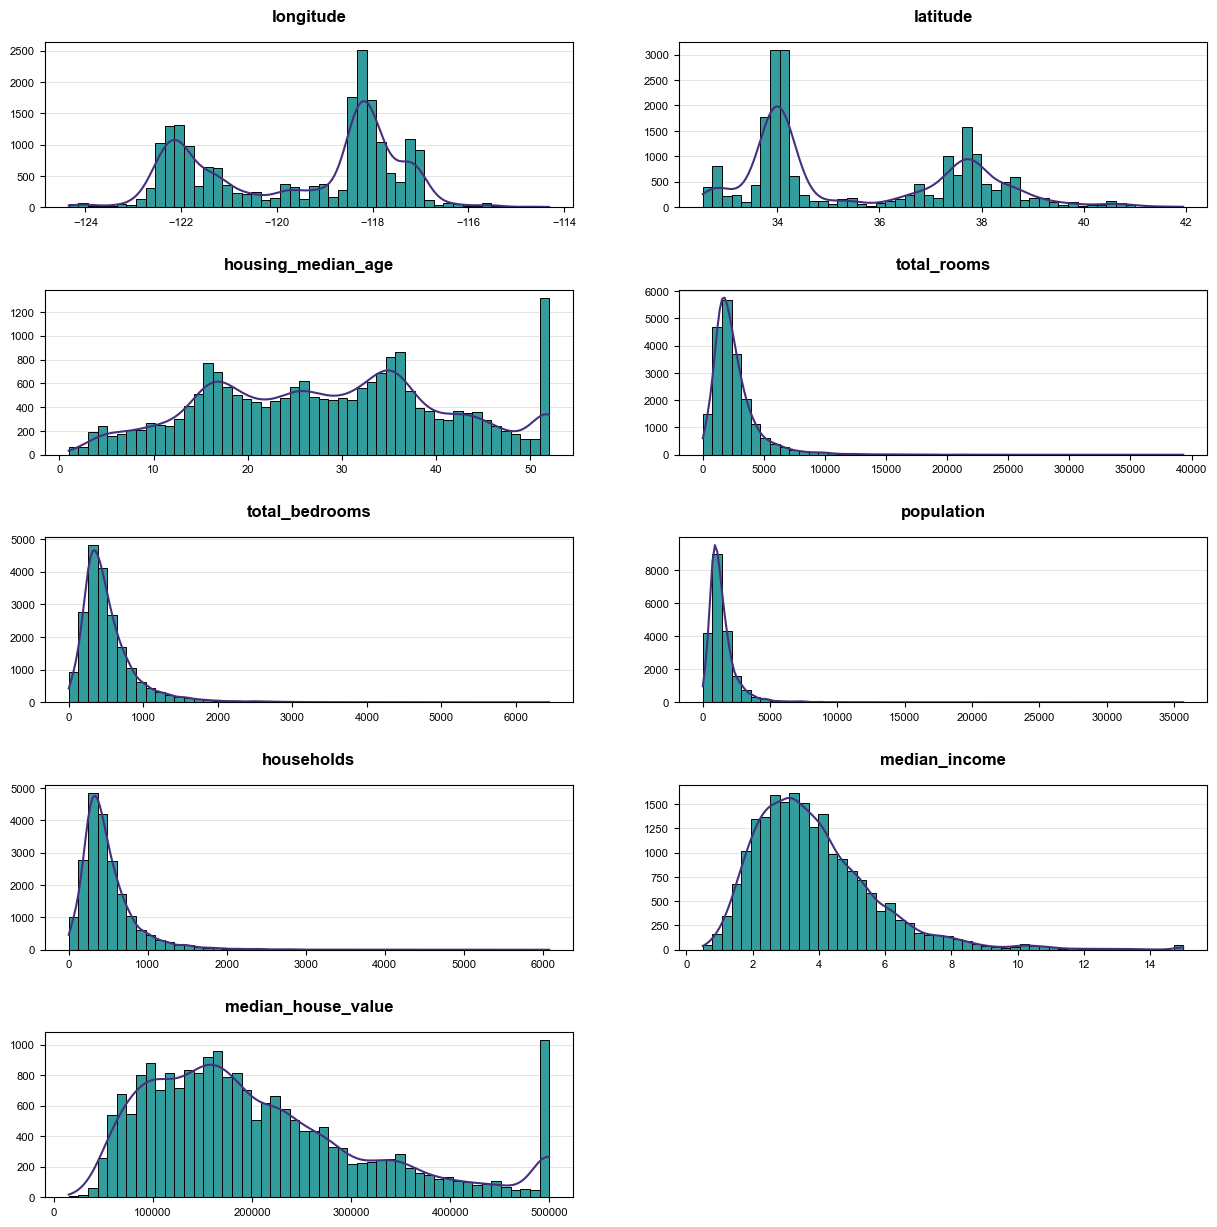

In [136]:
ut.multiHist('attribute_histogram', housingDf)

## Train and Test Sets

### Random Sampling

Creating a random sample for test and train datasets. This method is not suitable for incremental datasets and re-training because the entry of new data will affect the data in the training and test set. With the time, the model will learn all data from both sets.
 
This method is only suitable when the dataset is large enough for avoiding biases.

In [116]:
trainSet, testSet = ut.randomDataSplitter(housingDf, 0.2)

print(len(trainSet))
print(len(testSet))

16512
4128


Importing sklearn function for splitting data can do a similar task as the Custom function created `randomDataSplitter()`, but is more convenient thanks to the capability of define important parameters such as the random state.

In [117]:
trainSet, testSet = train_test_split(housingDf, test_size=0.2, random_state=42)

print(len(trainSet))
print(len(testSet))

16512
4128


### Stratified Sampling

Is a useful sampling used when the classes inside the dataset are not evenly distributed. In this sampling the data is stratified and then sampled acourding to the proportions of those strata.

For numeric values the data should be stratified through the prior assignation of labels for each interval of values.

In [118]:
housingDf['income_category'] = pd.cut(housingDf['median_income'], bins=[0,1.5,3,4.5,6,np.inf], labels=[1,2,3,4,5])
housingDf

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


Setting X and Y values for plotting a bar graph

In [119]:
incomeValueCount = housingDf['income_category'].value_counts()
incomeValueCount = incomeValueCount.sort_index()

x = incomeValueCount.index.values
y = np.array(incomeValueCount.values)

Checking value types for the customized graph function

In [16]:
print(type(y))
print(type(x))

<class 'numpy.ndarray'>
<class 'pandas.core.arrays.categorical.Categorical'>


Creating a bar graph for the Income Category values

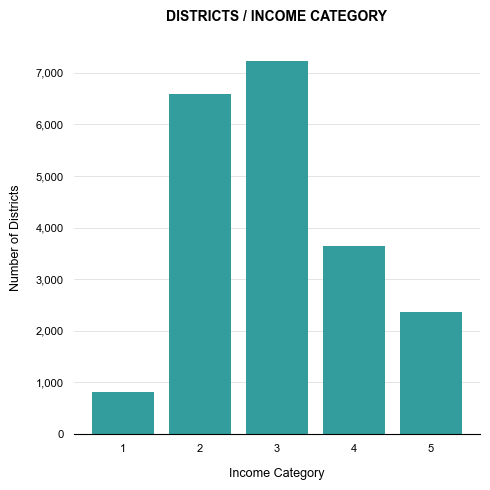

In [132]:
ut.barGraph('income_category_bar', x, y, 'DISTRICTS / INCOME CATEGORY', 'Income Category', 'Number of Districts')

Based on the category values, we can create a stratified train and test dataset using the train_test_split function.

In [18]:
stratTrain, stratTest = train_test_split(housingDf, test_size=0.2, stratify=housingDf['income_category'], random_state=42)

Here we are checking the proportions for each income categorical value in the test set

In [19]:
stratTest['income_category'].value_counts() / len(stratTest)

income_category
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Now is important to compare the proportions in the test set with the dataset ones.

The following table shows that the stratified sampling has a reduced bias in comparison to the original dataset. On the other hand, the random sampling is presenting a high bias.

In [22]:
def cat_proportions(data, category):
    return data[category].value_counts() / len(data)

prop_comparison = pd.DataFrame({
    'Overall %': cat_proportions(housingDf, 'income_category'),
    'Stratified %': cat_proportions(stratTest, 'income_category'),
    'Random %': cat_proportions(testSet, 'income_category')
    }).sort_index()

prop_comparison.index.name = 'Income Category'

prop_comparison['Strat. Error %'] = (prop_comparison['Stratified %'] / prop_comparison['Overall %'] - 1)
prop_comparison['Rand. Error %'] = (prop_comparison['Random %'] / prop_comparison['Overall %'] - 1)

(prop_comparison * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


The income category column will not be used anymore, so we can drop it.

In [23]:
for set in (stratTrain, stratTest):
    set.drop('income_category', axis=1, inplace=True)

## Data Exploration

This part of the project involves a high manipulation of the training set. For that reason, is important to make a copy first.

In [24]:
housing = stratTrain.copy()

The following function is downloading the california shape map data for plotting the longitude and latitude coordinates.

In [ ]:
ut.downloadCaliforniaMap()

data/geodata/ directory created
Zip file downloaded from https://gis-calema.opendata.arcgis.com/datasets/59d92c1bf84a438d83f78465dce02c61_0.zip?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D
Map Extracted into data/


Now we're instantiating the california map with the EPSG:4326 coordinates and the geometry representation with the `point()` object.

In [ ]:
californiaMap = gpd.read_file('data/geodata/California_County_Boundaries.shp')
californiaMap.to_crs(epsg=4326)

geometry = [Point(lon,lat) for lon,lat in zip(housing['longitude'], housing['latitude'])]
gdf = gpd.GeoDataFrame(housing, geometry=geometry, crs='EPSG:4326') # type: ignore

Then we have our point coordinates in the `geometry` column.

In [ ]:
gdf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category,geometry
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,2,POINT (-122.42000 37.80000)
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5,POINT (-118.38000 34.14000)
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,2,POINT (-121.98000 38.36000)
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,2,POINT (-117.11000 33.75000)
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3,POINT (-118.15000 33.77000)


### Map Plotting

Finally we are plotting the houses location.

We can quickly identify the zones with higher houses density and therefore, most of the zones with higher housing demand.

e:\david\Documents\ML-Projects\.venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


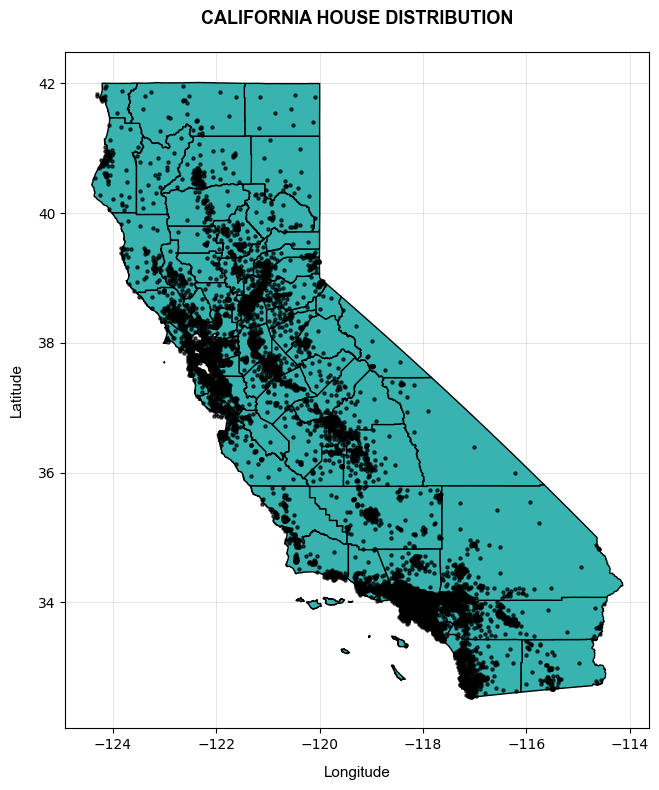

In [ ]:
# Set CRS for gdf to EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# Check the CRS of californiaMap and reproject if necessary
if californiaMap.crs != {'init': 'epsg:4326'}:
    californiaMap = californiaMap.to_crs(epsg=4326)

# Creating the graph axis and figure elements
fig, ax = plt.subplots(figsize=(8, 8))

# Setting the grid configuration
ax.grid(True, color='grey', linewidth='0.5', alpha=0.3)
ax.set_axisbelow(True)

ax.set_title('CALIFORNIA HOUSE DISTRIBUTION', loc='center', pad=20, weight='bold', fontsize=13, fontfamily='arial')

ax.set_xlabel('Longitude', labelpad=10, fontsize=11, fontfamily='arial')
ax.set_ylabel('Latitude', labelpad=10, fontsize=11, fontfamily='arial')

# Plotting the map shape
californiaMap.plot(ax=ax, color='#39B3B0', edgecolor='black') #type: ignore

# Plotting the houses location scatter plot
gdf.plot(ax=ax, marker='o', color='black', markersize=5, alpha=0.7) #type: ignore

ut.saveGraph('california_houses_distribution')

We can add a relevant dimension (color) to the map for a deeper analysis (median_house_values)

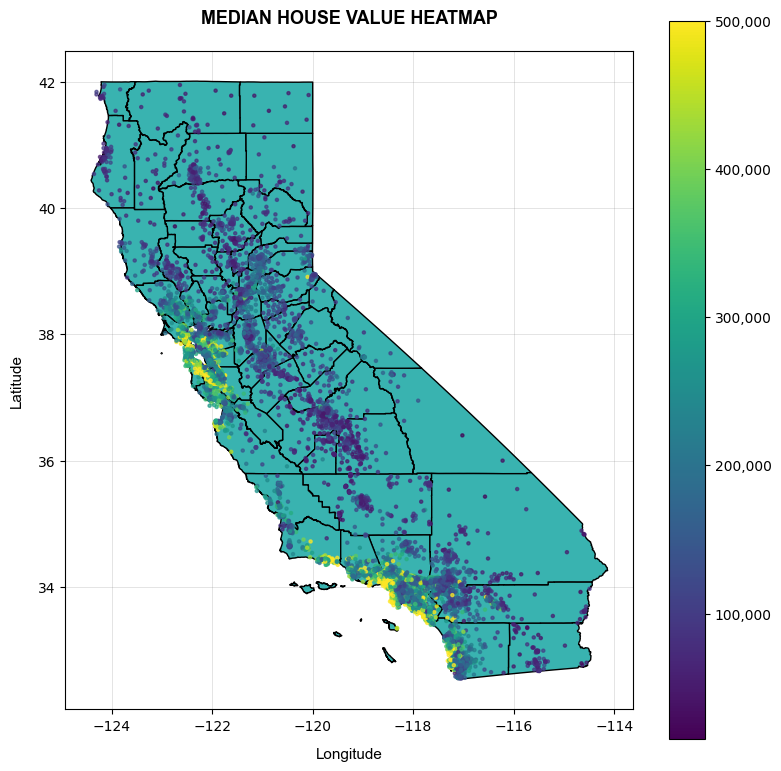

In [ ]:
# Creating the graph axis and figure elements
fig, ax = plt.subplots(figsize=(8, 8))

# Setting the grid configuration
ax.grid(True, color='grey', linewidth='0.5', alpha=0.3)
ax.set_axisbelow(True)

ax.set_title('MEDIAN HOUSE VALUE HEATMAP', loc='center', pad=20, weight='bold', fontsize=13, fontfamily='arial')

ax.set_xlabel('Longitude', labelpad=10, fontsize=11, fontfamily='arial')
ax.set_ylabel('Latitude', labelpad=10, fontsize=11, fontfamily='arial')

# Plotting the map shape
californiaMap.plot(ax=ax, color='#39B3B0', edgecolor='black') #type: ignore

# Plotting the houses location scatter plot
scatter_plot = gdf.plot(ax=ax,                        #type: ignore
                        marker='o', 
                        markersize=5, 
                        alpha=0.7, 
                        column='median_house_value', 
                        cmap='viridis', 
                        legend=True
                        )

colorbar = scatter_plot.get_figure().get_axes()[1] #type: ignore
colorbar.get_yaxis().set_major_formatter(ticker.FuncFormatter(ut.thousandsFormat))

ut.saveGraph('median_house_value_heatmap')

### Correlations

Is important to understand and analyze the correlation between the numeric variables. We can create a correlation matrix using the `.corr()` method of the pandas df.

In [28]:
corr_matrix = housingDf.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


To visualize better this correlation matrix we can plot a heatmap using seaborn.

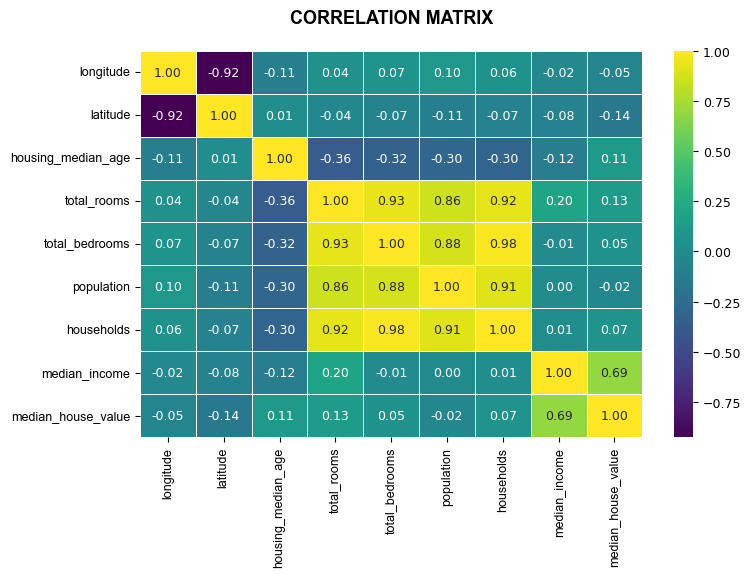

In [49]:
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5, annot_kws={"size": 9}) #type:ignore
plt.title('CORRELATION MATRIX', loc='center', pad=20, weight='bold', fontsize=13, fontfamily='arial')

# Decrease font size of column labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9, fontfamily='arial')
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9, fontfamily='arial')

ut.saveGraph('correlation_matrix')